<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import zipfile
import tensorflow as tf
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

In [2]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2120


In [4]:
batch_size = 1
img_height = 200
img_width = 200
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 2120 files belonging to 6 classes.
Using 1696 files for training.
Found 2120 files belonging to 6 classes.
Using 424 files for validation.
['Looking Away', 'bored', 'confused', 'drowsy', 'engaged', 'frustrated']


In [8]:
# Dimensions des images
img_height, img_width = 200, 200
num_classes = len(class_names)

# Chargement de ResNet50 pré-entraîné
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Congeler les couches de ResNet50 pré-entraînées
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches personnalisées pour la classification des étudiants par engagement
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)

# Compiler le modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Afficher un résumé du modèle
model.summary()
# Batch size
batch_size = 32
# Entraîner le modèle
epochs = 10  # Vous pouvez ajuster le nombre d'époques
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    batch_size=batch_size
)

# Évaluation du modèle
loss, accuracy = model.evaluate(val_data)
print("Accuracy on validation data:", accuracy)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

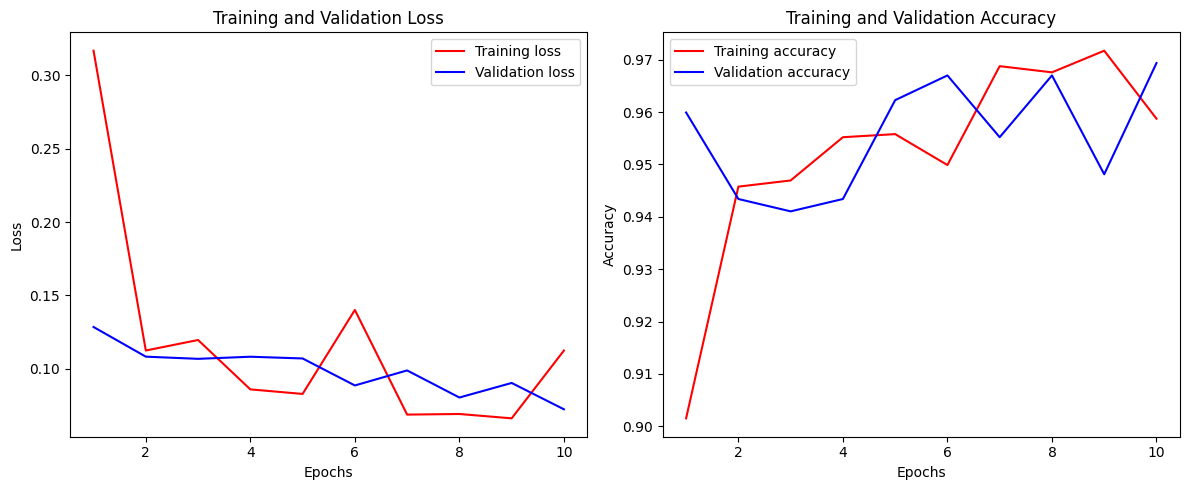

In [9]:
import matplotlib.pyplot as plt

# Récupérer les données d'entraînement de l'histoire
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Tracer les courbes de perte
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Tracer les courbes d'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Afficher les courbes
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Créer des listes pour stocker les prédictions et les étiquettes réelles
y_true = []
y_pred = []

# Prédictions du modèle sur les données de validation
for idx, (images, labels) in enumerate(val_data):
    predictions = model.predict(images)

    # Convertir les prédictions en classes prédites
    preds = np.argmax(predictions, axis=-1)

    y_true.extend(labels)
    y_pred.extend(preds)

    # Arrêt de la boucle après une itération complète sur les données de validation
    if idx == (len(val_data) - 1):
        break

# Convertir les listes en numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Filtrer les NaN dans y_true et y_pred
nan_indices = np.isnan(y_true) | np.isnan(y_pred)
y_true_filtered = y_true[~nan_indices]
y_pred_filtered = y_pred[~nan_indices]

# Calcul des mesures de performance
accuracy = accuracy_score(y_true_filtered, y_pred_filtered)
precision = precision_score(y_true_filtered, y_pred_filtered, average='weighted')
recall = recall_score(y_true_filtered, y_pred_filtered, average='weighted')
f1 = f1_score(y_true_filtered, y_pred_filtered, average='weighted')

# Affichage des mesures de performance
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))


1/1 [==============================] - 0s 161ms/step
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1-score: 0.97


In [21]:
#le rapport de classification
from sklearn.metrics import classification_report

# y_true_filtered : étiquettes réelles
# y_pred_filtered : prédictions du modèle

# Générer le rapport de classification
report = classification_report(y_true_filtered, y_pred_filtered)

# Afficher le rapport de classification
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        68
           1       0.94      0.87      0.90        70
           2       1.00      1.00      1.00        71
           3       0.85      0.93      0.89        57
           4       1.00      1.00      1.00        73
           5       1.00      1.00      1.00        85

    accuracy                           0.97       424
   macro avg       0.97      0.97      0.97       424
weighted avg       0.97      0.97      0.97       424

